In [1]:
!pip list

Package                       Version
----------------------------- --------------------
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     3.0.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcr

In [6]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data
import math

In [7]:
def getCloseDataPandas(ticker, start,end=None):
    #print("ticker: " ,ticker)
    return data.get_data_yahoo(ticker, start,end)['Close']

def getCloseData(ticker, start, end=None):
    #print("ticker: " ,ticker)
    return fdr.DataReader(ticker,start,end)['Close']

def getDayReturn(closeDataSet):
    return (closeDataSet/closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    
    #plt.figure(figsize=(15,5))
    #plt.plot(-dd, label="DrawDown")
    #plt.legend(fontsize = 16)
    mdd = dd.max()
    
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 1, 1)
    cumulativeReturn.plot(color="green")
    plt.ylabel("profit", fontsize=20)

    plt.subplot(2, 1, 2)
    plt.plot(-dd, color="red")
    plt.ylabel("draw down", fontsize=20)

    plt.show()

    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd


def getRebalancingDate(closeDataSet, period):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 

    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period , weightDf=None):
    if weightDf is None : 
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    else:
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
        for i in range(0, len(weightDf.columns)):
            print(weightDf.columns[i] , "비율 : ")
            weightDf[weightDf.columns[i]] = float(input())
            

    portfolio = pd.DataFrame()
    totalAsset = 1 
    start = rebalancingDate[0] 
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end] 
        cumReturn = getCumulativeReturn(priceData) 
        weightedCumReturn = weight * cumReturn 
        netCumReturn = totalAsset * weightedCumReturn
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumReturn])
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] 
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 


In [24]:
kospi = getCloseDataPandas("^KS11","1994-01","2022-09-30") 
TIGER10Bond = getCloseData("302190", "1994-1", "2022-09-30")

In [25]:
kospi

Date
1996-12-11     704.679993
1996-12-12     689.380005
1996-12-13     689.070007
1996-12-16     673.919983
1996-12-17     663.349976
                 ...     
2022-09-26    2220.939941
2022-09-27    2223.860107
2022-09-28    2169.290039
2022-09-29    2170.929932
2022-09-30    2155.489990
Name: Close, Length: 6360, dtype: float64

In [26]:
TIGER10Bond

Date
2018-07-20    48039
2018-07-23    48030
2018-07-24    47962
2018-07-25    47972
2018-07-26    48010
              ...  
2022-09-26    46525
2022-09-27    46720
2022-09-28    46795
2022-09-29    46725
2022-09-30    47060
Name: Close, Length: 1035, dtype: int64

In [27]:
closeDataSet = pd.concat([kospi,TIGER10Bond], axis=1)
closeDataSet.columns = ["kospi","TIGER10Bond"]
closeDataSet.dropna(inplace = True)

In [28]:
closeDataSet

,kospi,TIGER10Bond
Date,,
2018-07-20,2289.189941,48039.0
2018-07-23,2269.310059,48030.0
2018-07-24,2280.199951,47962.0
2018-07-25,2273.030029,47972.0
2018-07-26,2289.060059,48010.0
...,...,...
2022-09-26,2220.939941,46525.0
2022-09-27,2223.860107,46720.0
2022-09-28,2169.290039,46795.0


In [29]:
rebalancingDate = getRebalancingDate(closeDataSet, "year")
rebalancingDate

DatetimeIndex(['2018-09-28', '2019-09-30', '2020-09-29', '2021-09-30',
               '2022-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [30]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet,"year", 1)

kospi 비율 : 
0.6
TIGER10Bond 비율 : 
0.4


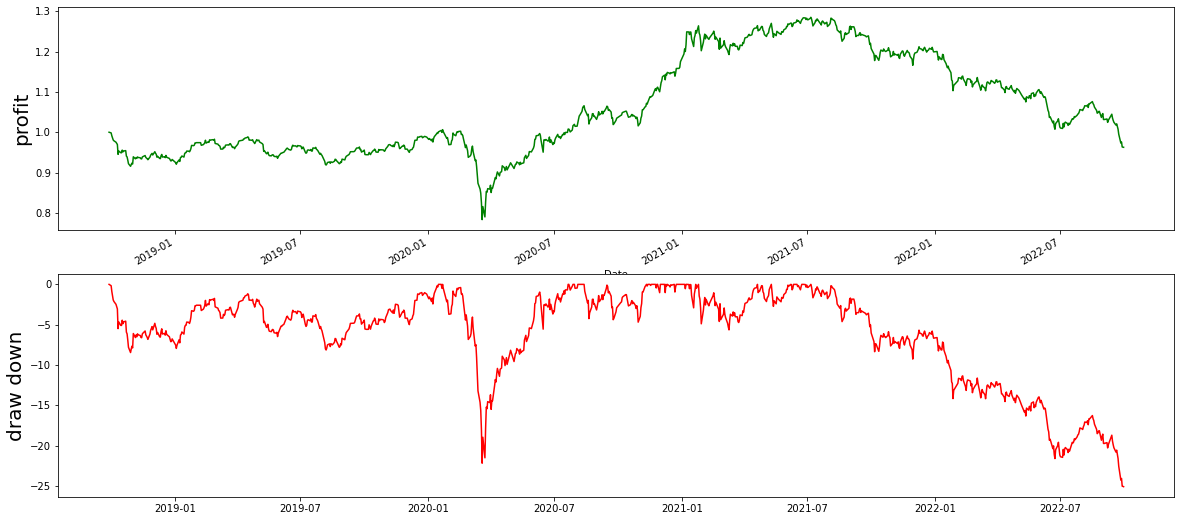

최종 수익률 : 0.9626407322790005
cagr: 0.9903258202079711
mdd: 25.082970384118052


In [31]:
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)